In [1]:
import jax3dp3 as j
import jax
import jax.numpy as jnp
import numpy as np
import os
import trimesh
import copy
import open3d as o3d
from tqdm import tqdm

intrinsics = j.Intrinsics(
    height=100,
    width=100,
    fx=100.0, fy=100.0,
    cx=50.0, cy=50.0,
    near=1.0, far=5000.0
)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
j.meshcat.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [7]:
table_params = (1000.0,
    1000.0,
    0.01,
    0.01,
    0.01)
table_mesh = j.mesh.make_table_mesh(
    *table_params
)
table_dims = j.utils.aabb(table_mesh.vertices)[0]
table_pose = j.t3d.inverse_pose(
    j.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 300.0, 50.0]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)
contact_plane = table_pose @ j.scene_graph.contact_planes(table_dims)[2]

In [419]:
occluder = j.mesh.make_cuboid_mesh(jnp.array([0.1, 100.0, 200.0]))                       
obj_a = j.mesh.make_cuboid_mesh(jnp.array([0.2, 70.0, 50.0]))                       
obj_b = j.mesh.make_cuboid_mesh(jnp.array([0.2, 50.0, 50.0]))
obj_c = j.mesh.make_cuboid_mesh(jnp.array([0.2, 90.0, 50.0]))
renderer = j.Renderer(intrinsics, num_layers=1024)
renderer.add_mesh(occluder)
renderer.add_mesh(obj_a)
renderer.add_mesh(obj_b)
renderer.add_mesh(obj_c)


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [432]:
object_indices = jnp.array([0,1])
poses = j.scene_graph.pose_from_contact_and_face_params_multiobject_jit(
    jnp.array(
        [
            [0.0, 0.0, 0.0],
            [50.0, -20.0, 0.5],
        ]
    ),
    jnp.array([3,3]),
    renderer.model_box_dims[object_indices],
    contact_plane
)

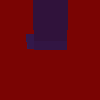

In [434]:
observed_point_cloud_image = renderer.render_multiobject(poses, object_indices)
j.meshcat.show_cloud("obs", observed_point_cloud_image[:,:,:3].reshape(-1,3) / 1000.0)
j.get_depth_image(observed_point_cloud_image[:,:,2])


In [435]:


contact_param_gridding_schedule = [
    j.make_translation_grid_enumeration_3d(
        -100.0, -100.0, -jnp.pi,
        100.0, 100.0, jnp.pi,
        5,5,3
    ),
    j.make_translation_grid_enumeration_3d(
        -30.0, -30.0, -jnp.pi/5,
        30.0, 30.0, jnp.pi/5,
        5,5,3
    ),
    j.make_translation_grid_enumeration_3d(
        -2.0, -2.0, -jnp.pi/5/5,
        2.0, 2.0, jnp.pi/5/5,
        5,5,3
    ),
    j.make_translation_grid_enumeration_3d(
        -0.0, -0.0, -jnp.pi,
        0.0, 0.0, jnp.pi,
        1,1,5*5*3
    ),
    j.make_translation_grid_enumeration_3d(
        -0.5, -0.5, -jnp.pi/5/5,
        0.5, 0.5, jnp.pi/5/5,
        5,5,3
    ),
    j.make_translation_grid_enumeration_3d(
        -5.0, -5.0, -jnp.pi/5/5,
        5.0, 5.0, jnp.pi/5/5,
        5,5,3
    ),
    j.make_translation_grid_enumeration_3d(
        -5.0, -5.0, -jnp.pi/5/5,
        5.0, 5.0, jnp.pi/5/5,
        5,5,3
    ),
    j.make_translation_grid_enumeration_3d(
        -5.0, -5.0, -jnp.pi/5/5,
        5.0, 5.0, jnp.pi/5/5,
        5,5,3
    ),
    j.make_translation_grid_enumeration_3d(
        -5.0, -5.0, -jnp.pi/5/5,
        5.0, 5.0, jnp.pi/5/5,
        5,5,3
    ),
    j.make_translation_grid_enumeration_3d(
        -5.0, -5.0, -jnp.pi/5/5,
        5.0, 5.0, jnp.pi/5/5,
        5,5,3
    ),
    j.make_translation_grid_enumeration_3d(
        -2.0, -2.0, 0.0,
        2.0, 2.0, 0.0,
        5,5,1
    ),
    j.make_translation_grid_enumeration_3d(
        -1.0, -1.0, 0.0,
        1.0, 1.0, 0.0,
        5,5,1
    ),
    j.make_translation_grid_enumeration_3d(
        -0.5, -0.5, 0.0,
        0.5, 0.5, 0.0,
        5,5,1
    ),
    j.make_translation_grid_enumeration_3d(
        -5.0, -5.0, 0.0,
        5.0, 5.0, 0.0,
        5,5,1
    ),
]

pose_from_contact_and_face_params_parallel_jit = jax.jit(jax.vmap(j.scene_graph.pose_from_contact_and_face_params, in_axes=(0,None, None, None)))


R_SWEEP = jnp.array([100.0, 50.0, 30.0]).reshape(-1,1)
print(R_SWEEP)
OUTLIER_PROBS = jnp.linspace(0.1, 0.1, 1)
OUTLIER_VOLUME = 1000.0**3
SCALING_FACTOR = 3

[[100.]
 [ 50.]
 [ 30.]]


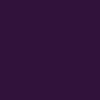

In [436]:
R = jnp.array([0.0001])
object_poses, object_ids = jnp.zeros((0,1,4,4)), []
reconstruction = renderer.render_multiobject(
    object_poses, object_ids
)


j.get_depth_image(reconstruction[:,:,2])

NORMALIZED SCORES   [0.0000000e+00 3.5900679e-01 6.4062405e-01 2.2128500e-37]
[2 1 3 0]
Best
[1.e-04 3.e+01 3.e+01] 0.1 2
[0, 2]


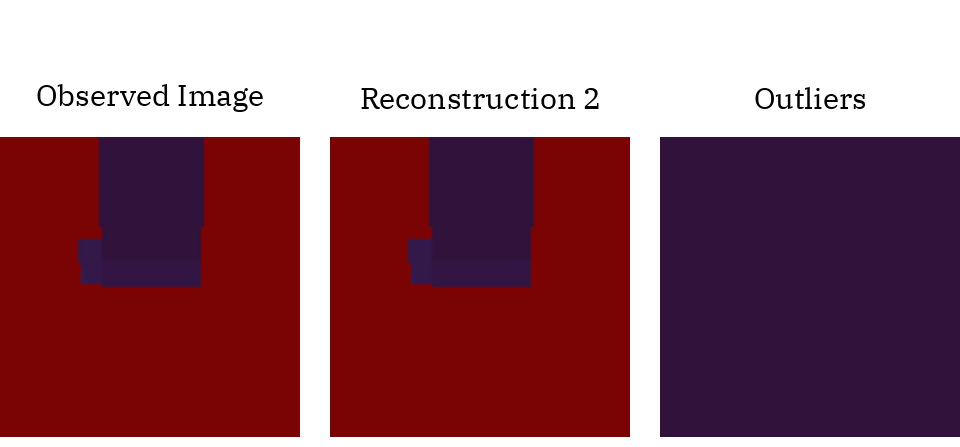

In [438]:
all_hypotheses = []
for obj_id in range(len(renderer.meshes)):

    contact_param = jnp.zeros(3)
    p = None
    for c2f_iter in range(len(contact_param_gridding_schedule)):
        contact_param_grid = contact_param_gridding_schedule[c2f_iter] + contact_param
        
        potential_new_object_poses = pose_from_contact_and_face_params_parallel_jit(
            contact_param_grid,
            3,
            renderer.model_box_dims[obj_id],
            contact_plane
        )
        POTENTIAL_R = jnp.hstack([jnp.tile(R[None,:], (R_SWEEP.shape[0], 1)),R_SWEEP])

        potential_poses = jnp.concatenate(
            [
                jnp.tile(object_poses, (1,potential_new_object_poses.shape[0],1,1)),
                potential_new_object_poses[None,...]
            ]
        )
        reconstruction = renderer.render_multiobject_parallel(
            potential_poses, object_ids + [obj_id]
        )
        p = j.threedp3_likelihood_multi_r_full_hierarchical_bayes_jit(
            observed_point_cloud_image,
            reconstruction[:,:,:,:3],
            reconstruction[:,:,:, -1],
            POTENTIAL_R, OUTLIER_PROBS, OUTLIER_VOLUME
        )
        ii,jj,kk = jnp.unravel_index(p.argmax(), p.shape)
        contact_param = contact_param_grid[ii]
#         print(POTENTIAL_R[jj])

    best_r, best_outlier_prob = (POTENTIAL_R[jj], OUTLIER_PROBS[kk])

    all_hypotheses.append(
        (p[ii,jj,kk], reconstruction[ii], best_r, best_outlier_prob, potential_poses[:,ii], obj_id)
    )

scores = jnp.array([i[0] for i in all_hypotheses])
print("NORMALIZED SCORES  ", j.utils.normalize_log_scores(scores))
print(jnp.argsort(-scores))
best_hypothesis = all_hypotheses[jnp.argmax(scores)]
score, reconstruction, best_r, best_outlier_prob, best_poses, obj_id = best_hypothesis
print("Best")
print(best_r, best_outlier_prob, obj_id)

R = best_r
object_poses = best_poses[:,None,...]
object_ids = object_ids + [obj_id]
print(object_ids)

outliers = (
    (1.0 - best_outlier_prob) * (j.gaussian_mixture_image_multi_r_jit(observed_point_cloud_image, reconstruction[:,:,:3], reconstruction[:,:, -1], best_r))
        <
    (best_outlier_prob / OUTLIER_VOLUME)
)

# height_factor = outlier_prob_viz.height / observed_image_viz.height

viz1 = j.multi_panel(
    [j.scale_image(j.get_depth_image(r[1][:,:,2]), SCALING_FACTOR) for r in all_hypotheses],
    labels=["{:d} : {:0.3f}".format(idx, i[0].item()) for (idx,i) in enumerate(all_hypotheses)]
)
depth_viz = j.scale_image(j.get_depth_image(observed_point_cloud_image[:,:,2]), SCALING_FACTOR)
outlier_viz = j.scale_image(j.get_depth_image(1.0 - outliers), SCALING_FACTOR)
viz2 = j.multi_panel(
    [
        depth_viz,
        j.scale_image(j.get_depth_image(reconstruction[:,:,2]), SCALING_FACTOR),
        outlier_viz
    ],
    labels=[
        "Observed Image",
        "Reconstruction {:d}".format(jnp.argmax(scores)),
        "Outliers",
    ],
    middle_width=30
)

viz2

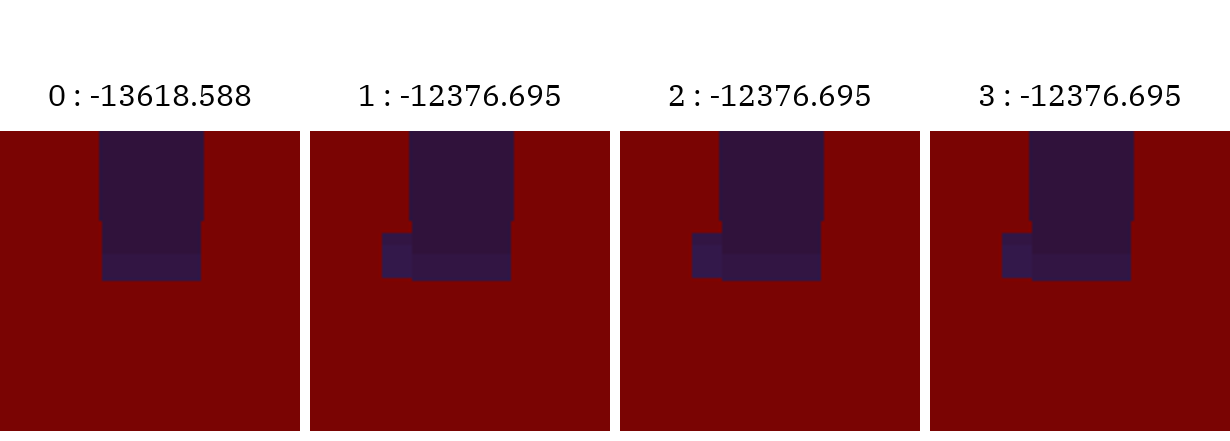

In [426]:
viz1

[1.e-04 3.e+01]


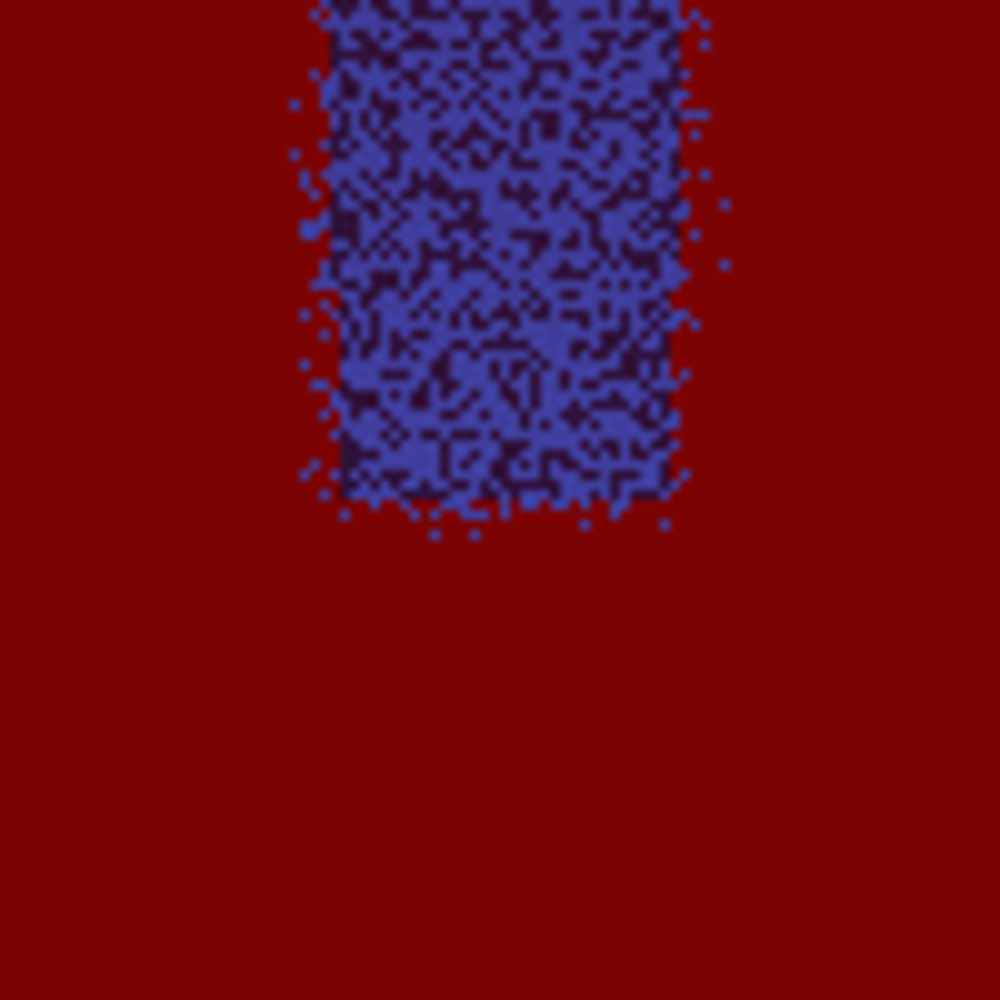

In [392]:
# R = jnp.array([0.0000001, 0.000001, 30.0])
reconstruction = renderer.render_multiobject(
    object_poses, object_ids
)

# reconstruction = observed_point_cloud_image
rendered_seg = reconstruction[:,:,3]
j.get_depth_image(reconstruction[:,:,2])
r_array = R
print(r_array, )
r = r_array[jnp.abs(rendered_seg[..., None] - jnp.arange(len(r_array))).argmin(-1)]
key = jax.random.PRNGKey(10)
noisy_point_cloud_image = jax.random.multivariate_normal(
    key, reconstruction[:,:,:3], (jnp.eye(3)[None, None, :, :] * r[:,:,None,None]), shape=r.shape
)
img = j.render_point_cloud(noisy_point_cloud_image.reshape(-1,3), intrinsics)
j.scale_image(j.get_depth_image(img[:,:,2]),10)